# Modeling and Performance Evaluation with Word Embeddings

The purpose of this notebook is to compare the performance of several models that utilize the word embedding method instead of the bag of words method

In [1]:
import gensim
from gensim import utils
import tempfile
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the genims model
model_name = 'gensim-model-i5jx6hf4'
model = gensim.models.Word2Vec.load(model_name)

## Binary Labels

The first section of this notebook will test the model's performance with binary labels, that is, positive (1) or negative (0) reviews. This will create a baseline model performance and will be compared to a multiclass case, as well as the other classifiers that used arrays generated from the bag-of-words and the tf-idf approaches.

### Re-create the dataframe using the model

In [3]:
# Define functions needed
# This calculates and returns an average word vector for a document
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for token in tokens:
        try:
            vec += model.wv[token].reshape((1, size))
            count += 1
        except KeyError: # handle out of vocabulary errors
            continue
    if count != 0:
        vec /= count
        return vec

# This calculates and returns the number of documents in a corpus so the array is constructed correctly
def calculate_num_docs(corpus):
    num_docs = 0
    for i, doc in enumerate(corpus):
        num_docs += 1
    return num_docs

In [4]:
# Import the reviews dataframe
yelp_reviews = pd.read_csv('yelp_reviews_v3.csv')
yelp_reviews.drop("Unnamed: 0", axis = 1, inplace = True)
yelp_reviews.head(5)

,date,review,rating,isEdited,title,userName,developerResponse
0,2024-11-22 22:44:23,I say it can be fantastic because some people ...,5,False,Yelp can be fantastic,Robg80,NaN
1,2024-12-12 22:08:33,Yelp's developers have been spamming false 5-s...,1,False,Review botting should not be tolerated!,itsbad):,NaN
2,2024-10-11 18:43:56,I will not be using Yelp ever again. After a t...,1,False,Horrible,jennausuwiajdneka,NaN
3,2024-09-22 20:35:32,During think tank meetings with other business...,1,False,Is yelp fair?,Srepman,"{'id': 46973211, 'body': 'Thank you for taking..."
4,2024-12-13 03:52:13,If I could give this place a 0 star I absolute...,1,False,Horrible service,Tsimmons96,NaN


In [5]:
# Extract the reviews and the ratings
reviews = yelp_reviews['review']
ratings = yelp_reviews['rating']

In [6]:
# Define a generator that will yield each document and preprocess it
class CorpusGenerator:
    def __iter__(self):
        for doc in yelp_reviews['review']:
            yield utils.simple_preprocess(doc)

In [7]:
# Use the functions to create the new dataframe
yelp_corpus = CorpusGenerator()

num_docs = calculate_num_docs(yelp_corpus) # calculate the number of docs to determine the number of rows needed

wordvec_arrays = np.zeros((num_docs, 300)) # 300 dimensions/features for each word vector

for i, doc in enumerate(yelp_corpus):
    wordvec_arrays[i, :] = word_vector(doc, 300) # change each row (doc) to the corresponding word vector
    
wordvec_df = pd.DataFrame(wordvec_arrays)

In [8]:
wordvec_df.shape

(20000, 300)

As shown, we have 300 features instead of the many more that came with the bag of words and tf-idf models

### Modeling with the wordvec dataframe

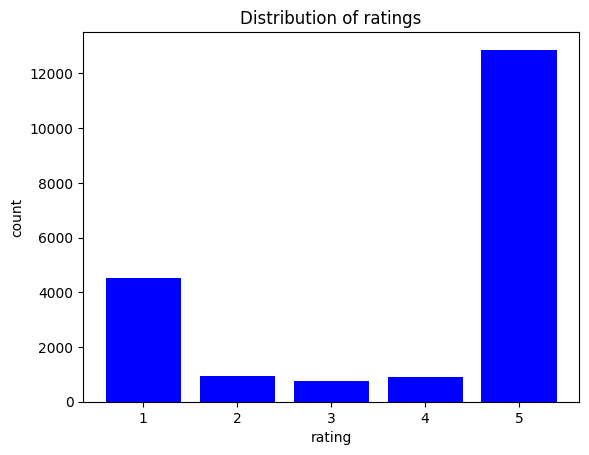

In [9]:
# View the distribution of ratings graphically
ratings_count = yelp_reviews.groupby(['rating'])['rating'].agg(['count'])
plt.figure()
plt.bar(ratings_count.index, ratings_count['count'], color = 'blue')
plt.xlabel('rating')
plt.ylabel('count')
plt.title('Distribution of ratings')
plt.show()

In [10]:
# View the distribution of ratings numerically
ratings_count

,count
rating,
1,4509
2,948
3,765
4,914
5,12864


The reviews will be combined to binary labels and downsampled.

In [11]:
# 1. Combine the labels with the data
wordvec_df['label'] = ratings

In [12]:
# 2. Combine rating categories 1 and 2, and 4 and 5, drop ratings with '3'
def recategorize(rating):
    if rating == 1 or rating == 2:
        return int(0) # negative reviews are given a 0
    elif rating == 4 or rating == 5:
        return int(1) # positive reviews are given a 1
    else:
        return np.nan

wordvec_df['label'] = wordvec_df['label'].apply(recategorize)

In [13]:
# 3. Separate the positive from the negative
positive_reviews = wordvec_df[wordvec_df['label'] == 1]
negative_reviews = wordvec_df[wordvec_df['label'] == 0]

# 4. Sample the positive
positive_reviews_sample = positive_reviews.sample(n = len(negative_reviews), random_state = 3)

# 5. Combine the data
wordvec_df_rebalanced = pd.concat([positive_reviews_sample, negative_reviews])

# 6. Sort according to index
wordvec_df_rebalanced_sorted = wordvec_df_rebalanced.sort_index()

# 7. Drop NaNs
wordvec_df_rebalanced_sorted.dropna(axis = 0, how = 'any', inplace = True)

wordvec_df_rebalanced_sorted

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
0,-0.227540,-0.170826,0.115066,0.149463,-0.026197,0.008393,-0.024517,0.025794,0.067489,0.097428,...,0.172643,0.034766,0.276930,0.098627,-0.086076,-0.055905,-0.056114,-0.002599,0.101394,1.0
1,-0.199238,-0.200579,0.116510,0.111658,-0.064551,0.020515,-0.017088,0.006766,0.083793,0.163523,...,0.178555,0.034858,0.283163,0.098012,-0.086388,-0.065492,-0.055511,-0.080624,0.102011,0.0
2,-0.229403,-0.180689,0.149343,0.133359,-0.036580,0.031731,-0.011592,-0.025878,0.081141,0.153825,...,0.177649,0.016944,0.292426,0.114490,-0.116326,-0.075048,-0.072371,-0.070862,0.127622,0.0
3,-0.237999,-0.193224,0.123863,0.154978,-0.065055,0.050980,0.001317,0.003766,0.086413,0.102024,...,0.149542,0.012284,0.302916,0.106729,-0.074216,-0.042382,-0.052624,-0.039711,0.112512,0.0
4,-0.203110,-0.214482,0.103448,0.181231,0.010507,-0.013264,-0.050693,0.035647,0.080304,0.143670,...,0.180557,0.059697,0.240646,0.098397,-0.047990,-0.073707,-0.052928,-0.058238,0.162846,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,-0.188254,-0.231851,0.100855,0.172398,-0.009157,-0.015677,-0.027036,0.053588,0.068399,0.138873,...,0.215877,0.087183,0.232958,0.146723,-0.068406,-0.098700,-0.021377,-0.020695,0.144141,0.0
19989,-0.182253,-0.172234,0.058293,0.203703,0.050997,-0.015876,0.031753,0.073073,0.035584,0.110737,...,0.202587,0.033387,0.257088,0.150562,-0.005578,-0.053920,-0.089609,0.087724,0.100026,1.0
19992,-0.204853,-0.164415,0.078403,0.061647,-0.105045,0.012298,-0.040401,0.035753,0.106387,0.142136,...,0.256079,0.077841,0.255793,0.098413,-0.079148,-0.095091,-0.058033,-0.058470,0.155490,0.0
19993,-0.177609,-0.170828,0.084600,0.101465,-0.090678,0.047323,0.019595,0.021610,0.057809,0.163601,...,0.188894,0.054218,0.292236,0.121689,-0.070115,-0.081535,-0.050719,-0.061766,0.096468,0.0


In [14]:
wordvec_df_rebalanced_sorted.groupby(['label'])['label'].agg(['count'])

,count
label,
0.0,5457
1.0,5456


Now the dataset is balanced and is combined into just positive and negative reviews

### Modeling

In [15]:
# Set up X and y
X = wordvec_df_rebalanced_sorted.drop('label', axis = 1)
y = wordvec_df_rebalanced_sorted['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [16]:
# Initialize the random forest classifier
rf_mdl = RandomForestClassifier(random_state = 3)

# Train the model
rf_mdl.fit(X_train, y_train)

# Make predictions about the test data
y_hat = rf_mdl.predict(X_test)

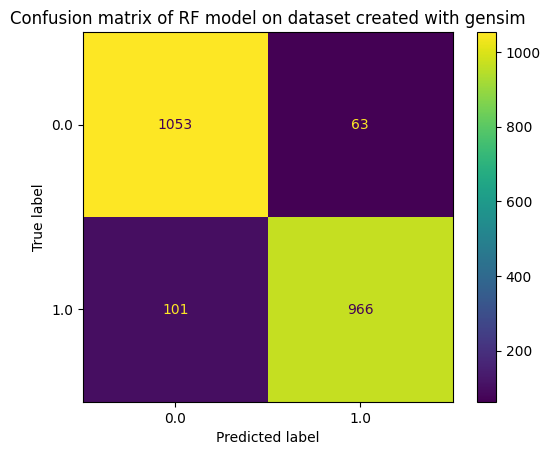

In [17]:
# Create a confusion matrix
cf = confusion_matrix(y_test, y_hat, labels = rf_mdl.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = rf_mdl.classes_)
disp.plot()
plt.title('Confusion matrix of RF model on dataset created with gensim')
plt.show()

In [18]:
# Print classification report
print(classification_report(y_test, y_hat, labels = rf_mdl.classes_))

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      1116
         1.0       0.94      0.91      0.92      1067

    accuracy                           0.92      2183
   macro avg       0.93      0.92      0.92      2183
weighted avg       0.93      0.92      0.92      2183



The model performance is great, with an f1-score of 0.92, a precision of 0.94, and a recall of 0.91. Now the performance with a multiclass problem will be measured.

## Multiclass labels

### Sample the original labels

In [19]:
# Covert the labels back to raw ones
wordvec_df.loc[:, 'label'] = ratings
wordvec_df['label']

0        5.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
19995    3.0
19996    5.0
19997    5.0
19998    5.0
19999    5.0
Name: label, Length: 20000, dtype: float64

In [20]:
# Display the distribution of labels
rating_counts = wordvec_df['label'].value_counts()
rating_counts.sort_index(inplace = True)
rating_counts

label
1.0     4509
2.0      948
3.0      765
4.0      914
5.0    12864
Name: count, dtype: int64

In [21]:
wordvec_df = wordvec_df.dropna(how = 'any', axis = 0)

In [22]:
# Store the smallest count in a variable
smallest_count = rating_counts.min()

# Separate the rating categories
one_stars = wordvec_df[wordvec_df['label'] == 1.0]
two_stars = wordvec_df[wordvec_df['label'] == 2.0]
three_stars = wordvec_df[wordvec_df['label'] == 3.0]
four_stars = wordvec_df[wordvec_df['label'] == 4.0]
five_stars = wordvec_df[wordvec_df['label'] == 5.0]

# Sample each of the labels according to the smallest label
one_stars = one_stars.sample(n = smallest_count, random_state = 3)
two_stars = two_stars.sample(n = smallest_count, random_state = 3)
three_stars = three_stars.sample(n = smallest_count, random_state = 3)
four_stars = four_stars.sample(n = smallest_count, random_state = 3)
five_stars = five_stars.sample(n = smallest_count, random_state = 3)

# Concatenate the dataframes and sort
wordvec_df_rebalanced = pd.concat([one_stars, two_stars, three_stars, four_stars, five_stars])
wordvec_df_rebalanced_sorted = wordvec_df_rebalanced.sort_index()

In [23]:
wordvec_df_rebalanced_sorted['label'].value_counts().sort_index()

label
1.0    765
2.0    765
3.0    765
4.0    765
5.0    765
Name: count, dtype: int64

We now have an equal number of counts for each label

### Modeling

In [24]:
# Set up X and y
X = wordvec_df_rebalanced_sorted.drop('label', axis = 1)
y = wordvec_df_rebalanced_sorted['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Create a random forest classfier
rf_mdl = RandomForestClassifier(random_state = 3)

# Train the model
rf_mdl.fit(X_train, y_train)

# Make predictions
y_hat = rf_mdl.predict(X_test)

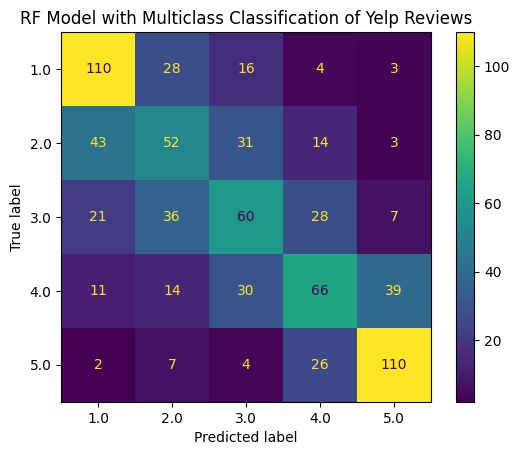

In [25]:
# View confusion matrix
cf = confusion_matrix(y_test, y_hat, labels = rf_mdl.classes_)
cf_disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = rf_mdl.classes_)

cf_disp.plot()
plt.title("RF Model with Multiclass Classification of Yelp Reviews")
plt.show()

In [26]:
# View classification report
print(classification_report(y_test, y_hat, labels = rf_mdl.classes_))

              precision    recall  f1-score   support

         1.0       0.59      0.68      0.63       161
         2.0       0.38      0.36      0.37       143
         3.0       0.43      0.39      0.41       152
         4.0       0.48      0.41      0.44       160
         5.0       0.68      0.74      0.71       149

    accuracy                           0.52       765
   macro avg       0.51      0.52      0.51       765
weighted avg       0.51      0.52      0.51       765



This model performed better than previous ones that were tasked with multiclassification. There is an interesting symmetrical pattern to it whereby the model seems to avoid making grave mistakes (for example, classifying a 1 as a 5, or classifying a 5 as a 1) but seems to struggle a bit with this level of granularity. f1-scores for 1s and 5s are much higher than the 2s, 3s, and 4s, indicating that the model is better at detecting extremes than it is at detecting a more neutral review. The model performed the worst with the 2s class, but there seems to be a difference of just 7 points between the 2s and 4s class, and 4 points between the 2s and 3s class. This is in contrast to 26 points between the 2s and 1s class, and 34 points between the 2s and 5s class.

Overall, this model, with its accuracy of 52%, is better than the baseline chance of 20% (randomly picking a class), but is still not great (may as well flip a coin to guess if the model will get the prediction right). **Is is possible that the model is overfitting?**

**Check for overfitting by evaluating the model on the training data**

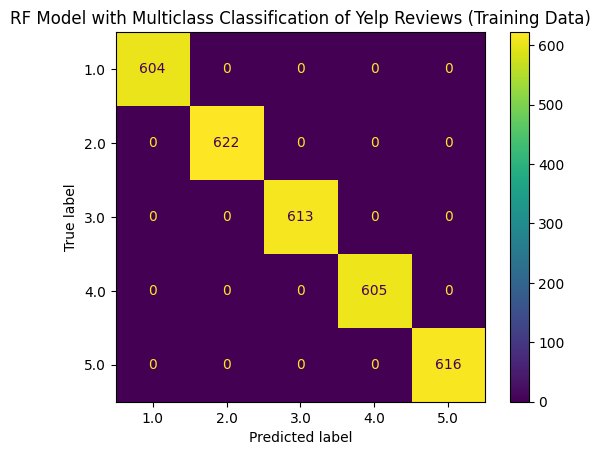

In [27]:
# Create a random forest classfier
rf_mdl = RandomForestClassifier(random_state = 3)

# Train the model
rf_mdl.fit(X_train, y_train)

# Make predictions
y_hat_train = rf_mdl.predict(X_train)

# Create a confusion matrix
cf_train = confusion_matrix(y_train, y_hat_train, labels = rf_mdl.classes_)
cf_train_disp = ConfusionMatrixDisplay(confusion_matrix = cf_train, display_labels = rf_mdl.classes_)

# Plot the confusion matrix
cf_train_disp.plot()
plt.title("RF Model with Multiclass Classification of Yelp Reviews (Training Data)")
plt.show()

In [28]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       604
         2.0       1.00      1.00      1.00       622
         3.0       1.00      1.00      1.00       613
         4.0       1.00      1.00      1.00       605
         5.0       1.00      1.00      1.00       616

    accuracy                           1.00      3060
   macro avg       1.00      1.00      1.00      3060
weighted avg       1.00      1.00      1.00      3060



The model definitely overfitted, so we'll need to tune some hyperparameters to prevent overfitting

In [29]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,...,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000,3825.000000
mean,-0.217670,-0.183689,0.103739,0.147995,-0.027310,0.008740,0.001061,0.040032,0.079898,0.131087,...,-0.021321,0.180048,0.054723,0.274601,0.113383,-0.062881,-0.076746,-0.057177,-0.028119,0.121948
std,0.037637,0.027261,0.024662,0.034476,0.035930,0.028261,0.026406,0.031220,0.023795,0.027504,...,0.027756,0.027930,0.029161,0.022769,0.023729,0.030252,0.022735,0.021551,0.039687,0.031130
min,-0.406548,-0.306723,-0.018080,-0.033575,-0.152559,-0.128290,-0.088308,-0.078065,0.007452,0.043162,...,-0.119176,0.058464,-0.053081,0.195702,0.013307,-0.194612,-0.179349,-0.145582,-0.164880,0.018616
25%,-0.240695,-0.201232,0.087776,0.126723,-0.051615,-0.008536,-0.016373,0.019149,0.064218,0.112134,...,-0.040662,0.161787,0.035866,0.259646,0.097693,-0.083407,-0.091476,-0.071413,-0.055951,0.100689
50%,-0.215494,-0.182508,0.103210,0.148748,-0.024896,0.009463,0.000742,0.040226,0.079319,0.131128,...,-0.023865,0.180338,0.055470,0.273941,0.113990,-0.064130,-0.076766,-0.057120,-0.030368,0.119094
75%,-0.194190,-0.165534,0.119005,0.171727,-0.002173,0.027188,0.018415,0.061214,0.094616,0.149973,...,-0.002437,0.198863,0.074120,0.289051,0.129090,-0.044429,-0.061988,-0.042756,-0.000853,0.142499
max,-0.066019,-0.052406,0.188035,0.254892,0.098848,0.121042,0.119362,0.152401,0.178313,0.233203,...,0.073277,0.295391,0.159034,0.370641,0.191086,0.078297,0.014484,0.019143,0.118522,0.227252


### Optimization using gridsearch

Import libraries

In [40]:
from sklearn.model_selection import GridSearchCV

Find the best hyperparameters and evaluate the performance

In [30]:
# Define a hyperparameter space
rf_param_space = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_leaf': [50, 200, 500, 1000],
    'max_features': ['sqrt', 50]
}

# Define a metric
metric = 'accuracy'

# Define a random forest model object
rf_mdl = RandomForestClassifier(random_state = 3)

# Define a gridsearchcv object
rf_mdl_gcv = GridSearchCV(estimator = rf_mdl, param_grid = rf_param_space, cv = 5, scoring = metric)

In [31]:
# Train the model
rf_mdl_gcv_results = rf_mdl_gcv.fit(X_train, y_train)

In [ ]:
##### Print out the best parameters found
rf_mdl_gcv_results.best_params_

In [33]:
# Print out the accuracy of the model on training data
rf_mdl_gcv_results.score(X_train, y_train)

0.6013071895424836

In [34]:
# Print out the accuracy of the model on testing data
rf_mdl_gcv_results.score(X_test, y_test)

0.4875816993464052

A good gridsearch would test very high bias, very high variance, and stuff in between.    
Random forest default hyperparameters:
- n_estimators = 100
- max_depth = None
- min_samples_leaf = 2
- max_featurs = 'sqrt'

So we'd want to test scenarios where we have few really deep trees and many really shallow trees

In [42]:
# Try again with different parameters (wide variety)
rf_param_space = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 500, 100, 5],
    'min_samples_leaf': [2, 50, 200, 500]
}

metric = 'accuracy'

rf_mdl_gcv = GridSearchCV(estimator = rf_mdl, param_grid = rf_param_space, cv = 5, scoring = metric)
rf_mdl_gcv_results = rf_mdl_gcv.fit(X_train, y_train)

In [43]:
rf_mdl_gcv_results.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}

In [44]:
rf_mdl_gcv_results.score(X_train, y_train)

1.0

In [45]:
rf_mdl_gcv_results.score(X_test, y_test)

0.4849673202614379

In [46]:
# Try again with different parameters (many shallow trees)
rf_param_space = {
    'n_estimators': [500, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [50, 20]
}

metric = 'accuracy'

rf_mdl_gcv = GridSearchCV(estimator = rf_mdl, param_grid = rf_param_space, cv = 5, scoring = metric)
rf_mdl_gcv_results = rf_mdl_gcv.fit(X_train, y_train)

In [47]:
rf_mdl_gcv_results.best_params_

{'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 200}

In [48]:
rf_mdl_gcv_results.score(X_train, y_train)

0.7408496732026144

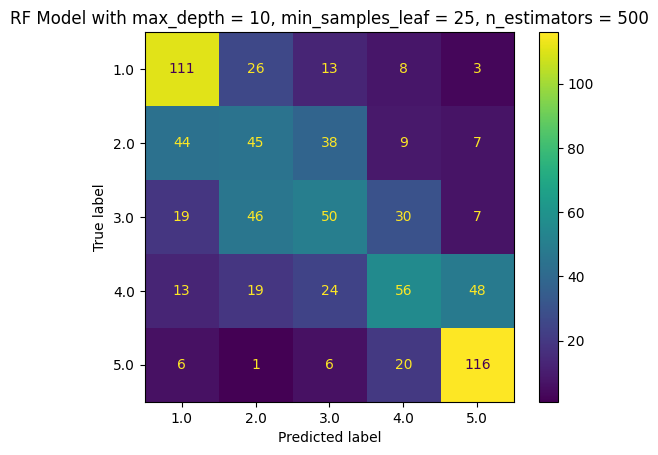

In [49]:
# Check the performance of this model
y_hat = rf_mdl_gcv_results.predict(X_test)

cf = confusion_matrix(y_test, y_hat, labels = rf_mdl_gcv_results.classes_)
cf_disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = rf_mdl_gcv_results.classes_)

# Plot the confusion matrix
cf_disp.plot()
plt.title("RF Model with max_depth = 10, min_samples_leaf = 25, n_estimators = 500")
plt.show()

In [50]:
print(classification_report(y_hat, y_test))

              precision    recall  f1-score   support

         1.0       0.69      0.58      0.63       193
         2.0       0.31      0.33      0.32       137
         3.0       0.33      0.38      0.35       131
         4.0       0.35      0.46      0.40       123
         5.0       0.78      0.64      0.70       181

    accuracy                           0.49       765
   macro avg       0.49      0.48      0.48       765
weighted avg       0.53      0.49      0.51       765



In [51]:
rf_mdl_gcv_results.score(X_test, y_test)

0.49411764705882355

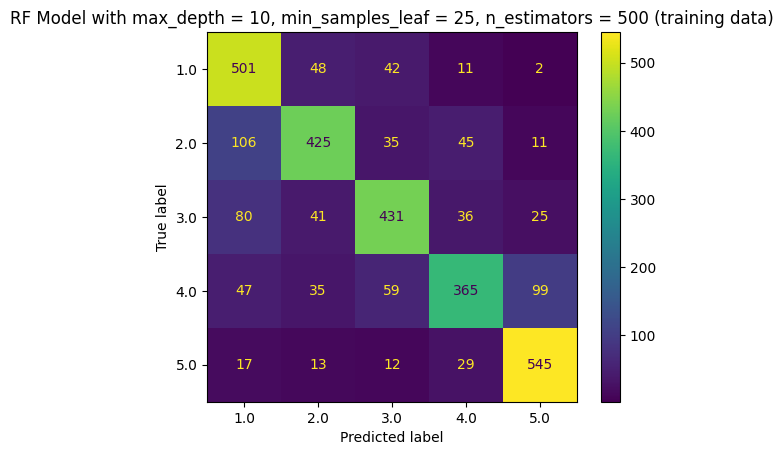

In [52]:
y_hat_train = rf_mdl_gcv_results.predict(X_train)

cf = confusion_matrix(y_train, y_hat_train, labels = rf_mdl_gcv_results.classes_)
cf_disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = rf_mdl_gcv_results.classes_)

# Plot the confusion matrix
cf_disp.plot()
plt.title("RF Model with max_depth = 10, min_samples_leaf = 25, n_estimators = 500 (training data)")
plt.show()

The accuracy here is a bit worse than the accuracy without the hyperparameter tuning. So there still seems to be a lot of overfitting going on.

### Logistic Regression

It would be beneficial to see if a logistic regression model could perform better than the random forest since it might be a little less complex/have less bias

In [30]:
# Import the library
from sklearn.linear_model import LogisticRegression

In [33]:
# Initialize the model
lr_mdl = LogisticRegression(max_iter = 500)

# Train the model
lr_mdl.fit(X_train, y_train)

# Make predictions
y_hat = lr_mdl.predict(X_test)

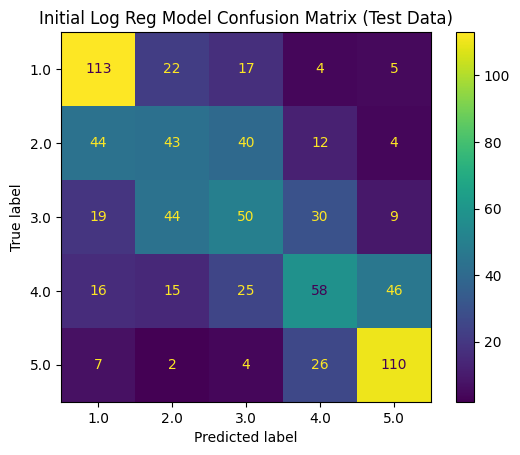

              precision    recall  f1-score   support

         1.0       0.57      0.70      0.63       161
         2.0       0.34      0.30      0.32       143
         3.0       0.37      0.33      0.35       152
         4.0       0.45      0.36      0.40       160
         5.0       0.63      0.74      0.68       149

    accuracy                           0.49       765
   macro avg       0.47      0.49      0.48       765
weighted avg       0.47      0.49      0.48       765



In [37]:
# Plot a confusion matrix and a classification report
def output_metrics(true, pred, cf_title, mdl):
    cf = confusion_matrix(true, pred, labels = mdl.classes_)
    cf_disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = mdl.classes_)
    cf_disp.plot()
    plt.title(cf_title)
    plt.show()
    print(classification_report(true, pred))

output_metrics(y_test, y_hat, "Initial Log Reg Model Confusion Matrix (Test Data)", lr_mdl)

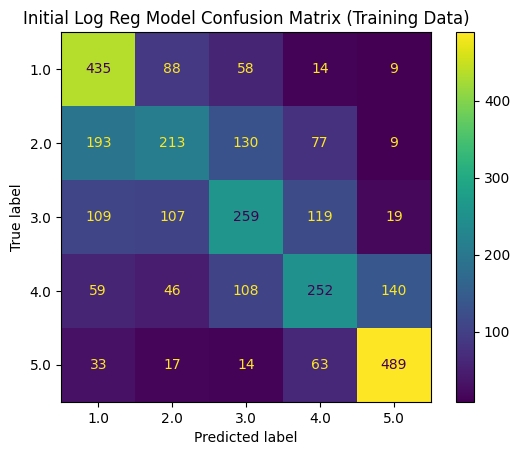

              precision    recall  f1-score   support

         1.0       0.52      0.72      0.61       604
         2.0       0.45      0.34      0.39       622
         3.0       0.46      0.42      0.44       613
         4.0       0.48      0.42      0.45       605
         5.0       0.73      0.79      0.76       616

    accuracy                           0.54      3060
   macro avg       0.53      0.54      0.53      3060
weighted avg       0.53      0.54      0.53      3060



In [38]:
y_hat_train = lr_mdl.predict(X_train)
output_metrics(y_train, y_hat_train, "Initial Log Reg Model Confusion Matrix (Training Data)", lr_mdl)

It's really interesting to see the difference in bias between these two models but seeing the testing performance remain about the same

### Optimization Using Gridsearch (for logistic regression)

In [52]:
# Initialize a parameter space
lr_param_space = {
    'penalty': ['l2'],
    'C': [0.1, 100, 1000, 5000]
}

metric = 'accuracy'

lr_mdl = LogisticRegression(max_iter = 10000)

# Initialize gridsearch model
lr_mdl_gcv = GridSearchCV(estimator = lr_mdl, param_grid = lr_param_space, cv = 5, scoring = metric)
lr_mdl_gcv_results = lr_mdl_gcv.fit(X_train, y_train)

In [53]:
lr_mdl_gcv_results.best_params_

{'C': 0.1, 'penalty': 'l2'}

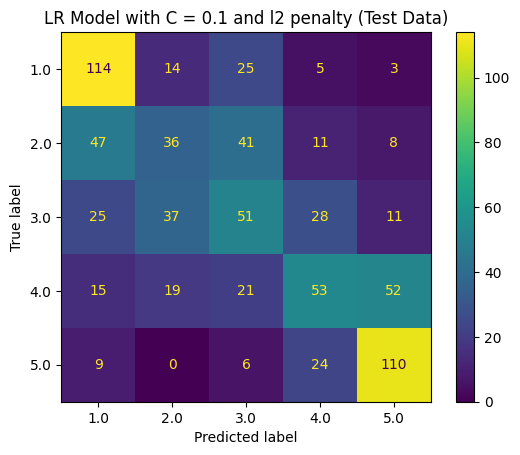

              precision    recall  f1-score   support

         1.0       0.54      0.71      0.61       161
         2.0       0.34      0.25      0.29       143
         3.0       0.35      0.34      0.34       152
         4.0       0.44      0.33      0.38       160
         5.0       0.60      0.74      0.66       149

    accuracy                           0.48       765
   macro avg       0.45      0.47      0.46       765
weighted avg       0.46      0.48      0.46       765



In [54]:
y_hat_gcv = lr_mdl_gcv_results.predict(X_test)
output_metrics(y_test, y_hat_gcv, "LR Model with C = 0.1 and l2 penalty (Test Data)", lr_mdl_gcv_results)

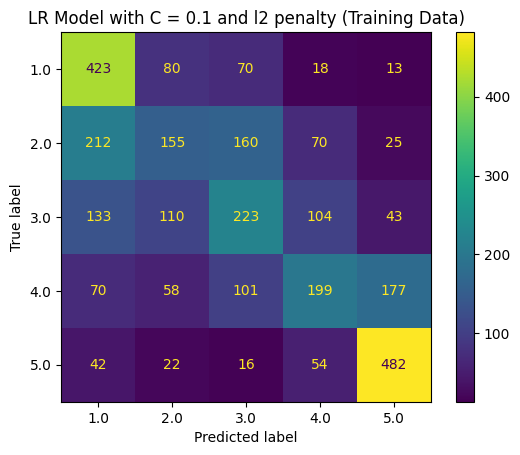

              precision    recall  f1-score   support

         1.0       0.48      0.70      0.57       604
         2.0       0.36      0.25      0.30       622
         3.0       0.39      0.36      0.38       613
         4.0       0.45      0.33      0.38       605
         5.0       0.65      0.78      0.71       616

    accuracy                           0.48      3060
   macro avg       0.47      0.48      0.47      3060
weighted avg       0.47      0.48      0.47      3060



In [55]:
y_hat_gcv_train = lr_mdl_gcv_results.predict(X_train)
output_metrics(y_train, y_hat_gcv_train, "LR Model with C = 0.1 and l2 penalty (Training Data)", lr_mdl_gcv_results)

Increasing the bias more seemed to make the model perform a bit worse, but it eliminated any overfitting. However, this seemed to be better than having the 
C penalty higher than 1. Seems like, from the results of all these tests, the data could just be too noisy for neutral reviews.